In [1]:
import functools
import operator
import pathlib
import gzip

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import seaborn as sns
import torch

import config
import plot_utils
import contacts
import utils

In [2]:
DATADIR = config.WORKING_DIR
#L = 15
L = config.L

model_prefix = "DHFR_incl_main_kit_taq"
include_main = True

#model_prefix = "DHFR_kit_taq"
#include_main = False

int_params = utils.load_torch_tensor(f"{DATADIR}/{model_prefix}_{L}_int_params.pt.gz")

if include_main:
    main_params = utils.load_torch_tensor(f"{DATADIR}/{model_prefix}_{L}_main_params.pt.gz")
else:
    main_params = int_params.exp().sum(axis=3).mean(axis=2).log()

q = int_params.shape[1]
print(f"main params shape: {main_params.shape}, int params shape: {int_params.shape}")

main params shape: torch.Size([186, 20]), int params shape: torch.Size([186, 20, 186, 20])


In [3]:
def normalize_main_params(main_params):
    # 2. Exponentiate to make positive
    main_params_exp = torch.exp(main_params)
    # 3. Normalize into a probability vector 
    return main_params_exp / main_params_exp.sum(1, keepdim=True)

def normalize_and_symmetrize_interaction_params(int_params):
    int_params_exp = torch.exp(int_params)
    int_params_prob = int_params_exp / int_params_exp.sum((1,3), keepdim=True) 
    # zero out diagonal terms. (In model.py we zero out when computing the log likelihood)
    int_params_prob[range(L), :, range(L), :] = 0.
    # symmetrize interaction parameters
    return (int_params_prob + int_params_prob.permute(2,3,0,1)) / 2.

int_params_prob = normalize_and_symmetrize_interaction_params(int_params)

if include_main:
    main_params_prob = normalize_main_params(main_params)
else:
    main_params_prob = int_params_prob.sum(axis=3).sum(axis=2) / (config.L - 1)

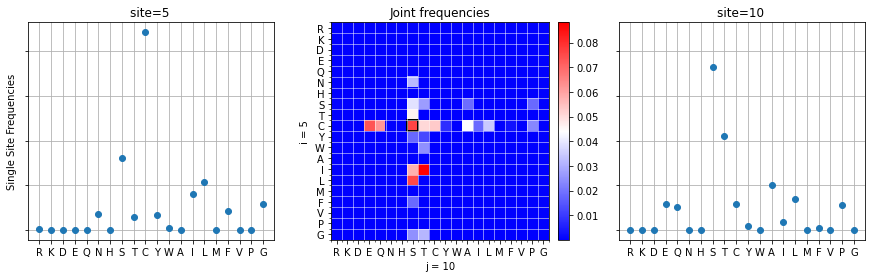

In [4]:
i_idx, j_idx = 5, 10

fig = plt.figure(figsize=(15, 4))
ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133, sharey=ax1)

ax = ax1
plot_utils.plot_biases_on_axis(ax, main_params_prob[i_idx, :], i_idx)
ax.set_title(f"site={i_idx} ")
ax.set_ylabel("Single Site Frequencies")

ax = ax2
plot_utils.plot_weights_on_axis(fig, ax, int_params_prob[i_idx, :, j_idx, :], i_idx, j_idx)
ax.set_title("Joint frequencies")

ax = ax3
plot_utils.plot_biases_on_axis(ax, main_params_prob[j_idx, :], j_idx)
ax.set_title(f"site={j_idx} ")
ax.set_ylabel("");
ax.set_yticklabels([]);



In [5]:
int_params_prob.shape

torch.Size([186, 20, 186, 20])

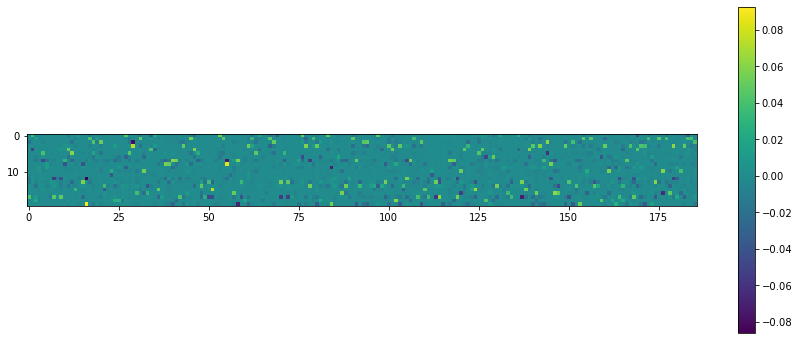

In [6]:
# Comparison  of Marginalization of pairwise probabilities to main effect probabilities
plt.figure(figsize=(15, 6))

plt.imshow(((int_params_prob.sum(axis=(2,3))  / (L-1)) - main_params_prob).t())
plt.colorbar()

## Convert frequencies to connected covariance matrix

Max correlation: 0.25, Min Correlation: -0.89
Max Eigenvalues: 5.54, Min Eigenvalue: -14.95


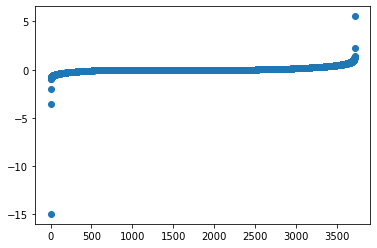

In [7]:
f_ijab = int_params_prob.reshape(L*q, L*q)
f_ia = main_params_prob.reshape(L*q)
f_ijab[torch.arange(L*q), torch.arange(L*q)] = f_ia
c_ijab = f_ijab - torch.einsum("i,j->ij", f_ia, f_ia)

print(f"Max correlation: {c_ijab.max():.2f}, Min Correlation: {c_ijab.min():.2f}")

eig = torch.symeig(c_ijab).eigenvalues
plt.plot(eig, 'o') # negative eigenvalues are bad but we fix it with regularization
print(f"Max Eigenvalues: {eig.max():.2f}, Min Eigenvalue: {eig.min():.2f}")

## Regularize to get inverse covariance matrix

In [8]:
reg_inv = eig.min().round().abs()
reg_inv = 50
inv_c = torch.inverse(c_ijab + reg_inv * torch.eye(L*q))
e_ijab = -inv_c.reshape(L,q,L,q)
print(reg_inv)

50


In [9]:
# e = -J (J is inverse covariance)
# h = Jmu - 1/2 diag(J)
# p(x) = exp(\sum_{i} h_i(x_i) + sum_{i < j} e_ij(x_i, x_j))
h_ia = (torch.einsum("ij,i->j", inv_c, f_ia) - 1/2. * torch.diag(inv_c)).reshape(L, q)

In [10]:
torch.save(h_ia.contiguous(), f"../working/{model_prefix}_mse_h_i_a.pt")
torch.save(e_ijab.contiguous(), f"../working/{model_prefix}_mse_e_i_a_j_b.pt")

e_ijab = e_ijab / 2.

## Contacts

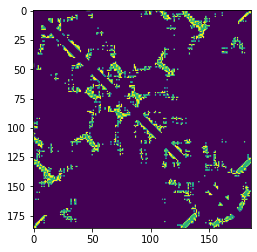

In [11]:
contact_mat_npy = contacts.get_DHFR_contact_matrix()[:L, :L]
contact_mat = torch.Tensor(contact_mat_npy)

plt.imshow(contact_mat)

In [12]:
total_count_5 = int((contact_mat == 5).sum().item() / 2)
total_count_5to8 = int((contact_mat == 8).sum().item() / 2)
total_count_8 = int(((contact_mat == 5) | (contact_mat == 8)).sum().item() / 2)

seq_runner = np.arange(1, config.L+1) # 1,2,...,186
# position 1 has 180 possible contacts
# position 2 has 179 possible contacts etc...
# summing up (and setting values <=0 to 0)
num_possible_contacts_seqdist_greater_5 = np.maximum(186 - 5 - seq_runner, 0).sum()
print(f"Number of possible contacts at sequence distance greater than 5 :",
       f"{num_possible_contacts_seqdist_greater_5}")

random_expectation_5 = total_count_5 / num_possible_contacts_seqdist_greater_5
random_expectation_5to8 = total_count_5to8 / num_possible_contacts_seqdist_greater_5
random_expectation_8 = total_count_8 / num_possible_contacts_seqdist_greater_5

print(f"Number of contacts at distance  <5A: {total_count_5:4d}, "
      f"random expectation : {random_expectation_5*100:.2f}%" )
print(f"Number of contacts at distance 5-8A: {total_count_5to8}, "
      f"random expectation : {random_expectation_5to8*100:.2f}%" )
print(f"Number of contacts at distance  <8A: {total_count_8}, "
      f"random expectation : {random_expectation_8*100:.2f}%" )


Number of possible contacts at sequence distance greater than 5 : 16290
Number of contacts at distance  <5A:  455, random expectation : 2.79%
Number of contacts at distance 5-8A: 1019, random expectation : 6.26%
Number of contacts at distance  <8A: 1474, random expectation : 9.05%


In [13]:
# Converting to zero-sum gauage to minimize frobenius norm (2013 Ekeberg Eqn 26)
eprime_ijab = e_ijab - e_ijab.mean(axis=1, keepdim=True) \
                     - e_ijab.mean(axis=3, keepdim=True) \
                     + e_ijab.mean(axis=(1,3), keepdim=True)

In [59]:
frob_norms = torch.norm(eprime_ijab, dim=(1,3))

In [70]:
frob_norms[2-2, 8-2]

tensor(2.6826e-05)

In [67]:
with open(f"{config.ASSETS_DIR}/frobenius_norms.npy", 'wb') as f:
    frob_norms_numpy = frob_norms.numpy()
    np.fill_diagonal(frob_norms_numpy, 0.)
    np.save(f, frob_norms_numpy )

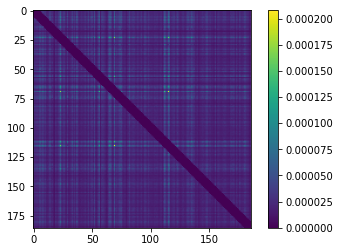

In [15]:
i_indices = torch.arange(L).expand(L, L)
j_indices = torch.arange(L).expand(L, L).t()

close_mask = (i_indices - j_indices).abs() <= 5
frob_norms[close_mask] = 0

plt.imshow(frob_norms)
plt.colorbar();

In [16]:
frob_norms

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.9162e-05, 1.1907e-05,
         1.3969e-05],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.4703e-05, 1.6027e-05,
         1.6909e-05],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.4245e-05, 1.4154e-05,
         1.6132e-05],
        ...,
        [1.9162e-05, 2.4703e-05, 2.4245e-05,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.1907e-05, 1.6027e-05, 1.4154e-05,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.3969e-05, 1.6909e-05, 1.6132e-05,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])

## Functional Data from Uniprot 
[Link to Uniprot page for mDHFR](https://www.uniprot.org/uniprot/P00375)

In [17]:
uniprot_binding_sites = [10, 65, 71]
uniprot_nucleotide_binding_ranges = \
                        [(16, 22), (55, 57), (77, 79), (117,125)]

def create_list_range(edges):
    start, stop = edges # edges is a tuple of length 2
    return list(range(start, stop+1))

uniprot_nucleotide_binding_regions = \
    functools.reduce(operator.add, map(create_list_range, 
                                       uniprot_nucleotide_binding_ranges))
def uniprot_func(uniprot_idx):
    ret = "None"
    if uniprot_idx in uniprot_binding_sites:
        ret = "Binding Site"
    elif uniprot_idx in uniprot_nucleotide_binding_regions:
        ret = "Binding Region"
    return ret

print("Number of functional sites : "
      f"{len(uniprot_binding_sites + uniprot_nucleotide_binding_regions)}")

Number of functional sites : 25


## Results

In [52]:
scores = pd.DataFrame({"i":i_indices.numpy().flatten(), "j":j_indices.numpy().flatten(), 
                        "frob":frob_norms.numpy().flatten()
                      })

def get_top_results_from_scores(scores, scores_col_name="frob", filter_close=True):
    results = scores.copy()
    results["contact"] = contact_mat_npy[results.i, results.j]
    results["ijdiff"] = (results.i - results.j).abs()
    results["wt_i"] = results.i.map(lambda x: config.WT_AA[x])
    results["wt_j"] = results.j.map(lambda x: config.WT_AA[x])
    results["uniprot_i"] = results.i + 2
    results["uniprot_j"] = results.j + 2
    results["uniprot_func_i"] = results.uniprot_i.map(uniprot_func)
    results["uniprot_func_j"] = results.uniprot_j.map(uniprot_func)
    results["contact"] = pd.Categorical(results.contact).rename_categories(
                                {0:"no contact", 5:"<5A", 8:"5-8A"})
    if filter_close:
        results_top = results[(results.i < results.j) & (results.ijdiff > 5)
                             ].sort_values(scores_col_name, ascending=False).copy()
    else:
        results_top = results[(results.i < results.j)
                             ].sort_values(scores_col_name, ascending=False).copy()
    return results_top

results_top = get_top_results_from_scores(scores, "frob")

# pretty print dataframe
uniprot_cols_to_print = ["i", "j", "ijdiff",  "frob", "uniprot_i", "uniprot_j" ,
                         "wt_i", "wt_j", "contact", "uniprot_func_i", "uniprot_func_j"]
results_top.reset_index(drop=True).head(20)[uniprot_cols_to_print]

,i,j,ijdiff,frob,uniprot_i,uniprot_j,wt_i,wt_j,contact,uniprot_func_i,uniprot_func_j
0,69,115,46,0.000208,71,117,R,G,no contact,Binding Site,Binding Region
1,23,69,46,0.000175,25,71,W,R,no contact,None,Binding Site
2,69,112,43,0.000164,71,114,R,W,5-8A,Binding Site,None
3,23,115,92,0.000162,25,117,W,G,no contact,None,Binding Region
4,56,69,13,0.000157,58,71,W,R,5-8A,None,Binding Site
5,23,112,89,0.000138,25,114,W,W,no contact,None,None
6,23,56,33,0.000131,25,58,W,W,no contact,None,None
7,56,115,59,0.000127,58,117,W,G,5-8A,None,Binding Region
8,56,112,56,0.000123,58,114,W,W,no contact,None,None
9,65,115,50,0.000120,67,117,P,G,no contact,None,Binding Region


In [19]:
results_top_20 = results_top.reset_index(drop=True).head(20)
results_top_20.index += 1
results_top_20 = results_top_20.drop(columns=["i", "j"])

results_top_20.columns = ["Frobenius Score", "Contact", "Residue distance", "AA1", "AA2", 
                          "Res1", "Res2", "Res1 Function", "Res2 Function"]
results_top_20 = results_top_20[["Res1", "Res2", "AA1", "AA2", "Residue distance", 
                                 "Frobenius Score", "Contact",    
                                  "Res1 Function", "Res2 Function"]]

In [20]:
results_top_20["Contact"] = results_top_20.Contact.cat.rename_categories(["no contact", r"\textless 5\angstrom", 
                                                                          r"5-8\angstrom"])
results_top_20

,Res1,Res2,AA1,AA2,Residue distance,Frobenius Score,Contact,Res1 Function,Res2 Function
1,71,117,R,G,46,0.000208,no contact,Binding Site,Binding Region
2,25,71,W,R,46,0.000175,no contact,None,Binding Site
3,71,114,R,W,43,0.000164,5-8\angstrom,Binding Site,None
4,25,117,W,G,92,0.000162,no contact,None,Binding Region
5,58,71,W,R,13,0.000157,5-8\angstrom,None,Binding Site
6,25,114,W,W,89,0.000138,no contact,None,None
7,25,58,W,W,33,0.000131,no contact,None,None
8,58,117,W,G,59,0.000127,5-8\angstrom,None,Binding Region
9,58,114,W,W,56,0.000123,no contact,None,None
10,67,117,P,G,50,0.000120,no contact,None,Binding Region


In [21]:
top_20_interactions_filename = pathlib.Path(config.ASSETS_DIR)/"top_20_interactions.tex"
with open(top_20_interactions_filename, "wt") as fh:
    print(results_top_20.to_latex(escape=False, 
                                  column_format="lrrrrp{1.5cm}p{1.7cm}p{1.7cm}p{2.0cm}p{2.8cm}",
                                  label="table:top_20_interactions",
                                  caption="Top 20 long range interaction predictions"
                                 ), file=fh)
    
# Add late position  to table. 
# This is redundant in pandas version 1.2 as there is a position argument 
# but do this manually till we upgrade
with open(top_20_interactions_filename, "rt") as fh:
    lines = fh.readlines()
    
lines[0] = lines[0].rstrip() + "[hb]\n"
with open(top_20_interactions_filename, "wt") as fh:
    fh.writelines(lines)

In [22]:
# makecells if we want to
#lines[6] = lines[6].replace("Residue distance &", "\makecell[l]{Residue distance} &")

In [23]:
# Save top L2 contacts
top_L2_contacts = results_top[["i", "j", "wt_i", "wt_j"]][:int(2*L)]
# convert to pdb indexing
top_L2_contacts.i += 1
top_L2_contacts.j += 1

top_L2_contacts.reset_index(drop=True)
top_L2_contacts.to_csv(f"../working/{model_prefix}_TOP_2L_CONTACTS.csv", index=False, header=False)

### Load Sanderlab reweighting results and untouched results

In [24]:
test_plmc_dir = pathlib.Path("../DHFR/Gen15/test_plmc")
test_plmc_dir = test_plmc_dir.expanduser()

In [25]:
# wt_remove in filename means that Sequences below wt mean was removed and WT was added back in
plmc_filename_with_wt = test_plmc_dir / "plmc_Gen15_wt_remove.txt"
plmc_file_untouched = test_plmc_dir / "plmc_Gen15_untouched.txt"


def get_scores_file(plmc_filename):
    return pd.DataFrame(contacts.with_read_plmc_coupling_scores_filename(
                        plmc_filename)).rename(columns={"idx1":"i", "idx2":"j", "score":"frob"})

In [26]:
gen15_with_wt_scores = get_scores_file(plmc_filename_with_wt)
gen15_with_wt_results_top = get_top_results_from_scores(gen15_with_wt_scores)
gen15_with_wt_results_top.reset_index(drop=True).head(20)[uniprot_cols_to_print]

,i,j,ijdiff,frob,uniprot_i,uniprot_j,wt_i,wt_j,contact,uniprot_func_i,uniprot_func_j
0,97,107,10,0.865747,99,109,R,K,no contact,None,None
1,39,48,9,0.762520,41,50,T,L,no contact,None,None
2,165,185,20,0.572155,167,187,L,D,no contact,None,None
3,63,79,16,0.532288,65,81,N,K,no contact,Binding Site,None
4,141,154,13,0.518743,143,156,F,K,no contact,None,None
5,20,32,12,0.482770,22,34,D,Y,no contact,Binding Region,None
6,143,165,22,0.421960,145,167,S,L,no contact,None,None
7,121,127,6,0.394742,123,129,Q,P,no contact,Binding Region,None
8,117,127,10,0.373453,119,129,S,P,no contact,Binding Region,None
9,25,36,11,0.346778,27,38,P,M,no contact,None,None


In [27]:
gen15_untouched_scores = get_scores_file(plmc_file_untouched)
gen15_untouched_results_top = get_top_results_from_scores(gen15_untouched_scores)
gen15_untouched_results_top.reset_index(drop=True).head(20)[uniprot_cols_to_print]

,i,j,ijdiff,frob,uniprot_i,uniprot_j,wt_i,wt_j,contact,uniprot_func_i,uniprot_func_j
0,130,141,11,2.064817,132,143,L,F,no contact,None,None
1,141,154,13,1.974806,143,156,F,K,no contact,None,None
2,85,106,21,1.873902,87,108,A,S,no contact,None,None
3,97,107,10,1.855961,99,109,R,K,no contact,None,None
4,39,48,9,1.835817,41,50,T,L,no contact,None,None
5,144,179,35,1.713037,146,181,D,E,no contact,None,None
6,84,91,7,1.644176,86,93,G,S,no contact,None,None
7,179,185,6,1.621751,181,187,E,D,no contact,None,None
8,84,110,26,1.617469,86,112,G,M,no contact,None,None
9,18,39,21,1.596201,20,41,N,T,no contact,Binding Region,None


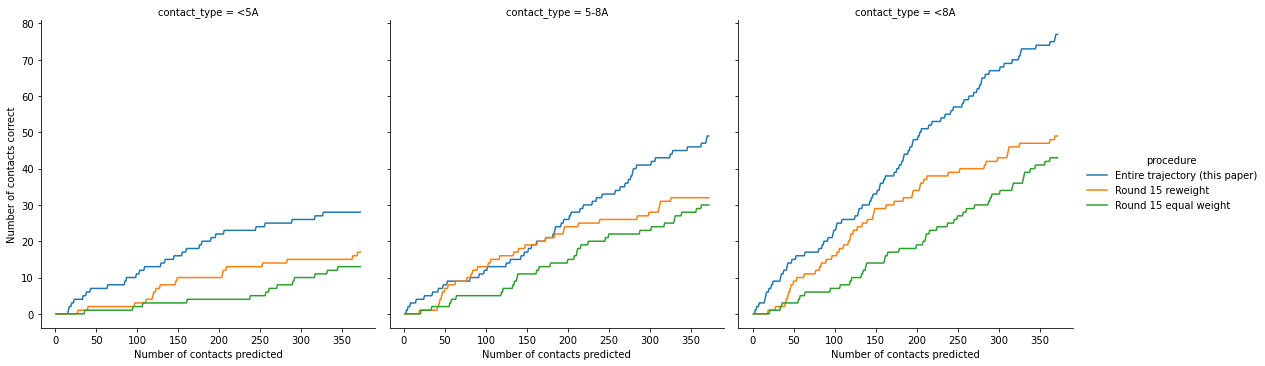

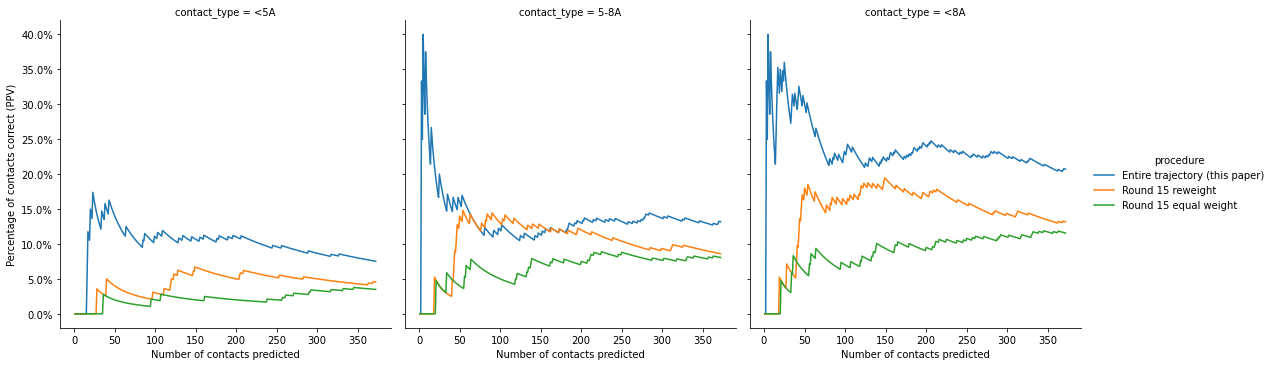

In [28]:
predict_to = 2 * L
contact_strings = ("<5A", "5-8A")


def count_cumsum_contacts(sorted_contact_arr, contact_str):
    return (sorted_contact_arr == contact_str).cumsum()[:predict_to].to_numpy()

def get_cumsum_contacts_as_dataframe(sorted_contact_arr, contact_arr_name):
    ret = pd.DataFrame({contact_str:count_cumsum_contacts(sorted_contact_arr, contact_str) 
                                 for contact_str in contact_strings})
    ret["<8A"] = ret["<5A"] + ret["5-8A"]
    ret["procedure"] = contact_arr_name
    ret["num_predicted"] = ret.reset_index()["index"] + 1
    return pd.melt(ret, id_vars=["procedure", "num_predicted"], var_name="contact_type", 
                                   value_name="num_correct")
    return ret


df_to_plot = pd.concat([get_cumsum_contacts_as_dataframe(sorted_contact_arr, contact_arr_name) for
                         sorted_contact_arr, contact_arr_name in [
                             (results_top.contact, "Entire trajectory (this paper)"),
                             (gen15_with_wt_results_top.contact, "Round 15 reweight"),
                             (gen15_untouched_results_top.contact, "Round 15 equal weight")]])

df_to_plot["pct_correct_ppv"] = df_to_plot.num_correct / df_to_plot.num_predicted

g = sns.relplot(x="num_predicted", y="num_correct", hue="procedure", kind="line", 
                col="contact_type", data=df_to_plot)
g.set_axis_labels("Number of contacts predicted", "Number of contacts correct")
g = sns.relplot(x="num_predicted", y="pct_correct_ppv", hue="procedure", kind="line", 
                col="contact_type", data=df_to_plot)
g = g.set_axis_labels("Number of contacts predicted", "Percentage of contacts correct (PPV)")
#g = g.set(ylim=(0,1))


for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))


    
pass

In [29]:
df_to_plot.num_correct.max()

77

In [30]:
df_to_plot.head()

,procedure,num_predicted,contact_type,num_correct,pct_correct_ppv
0,Entire trajectory (this paper),1,<5A,0,0.0
1,Entire trajectory (this paper),2,<5A,0,0.0
2,Entire trajectory (this paper),3,<5A,0,0.0
3,Entire trajectory (this paper),4,<5A,0,0.0
4,Entire trajectory (this paper),5,<5A,0,0.0


In [31]:
df_to_plot_melt = pd.melt(df_to_plot, id_vars=["procedure", "num_predicted", "contact_type"], 
        value_vars=["num_correct", "pct_correct_ppv"])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


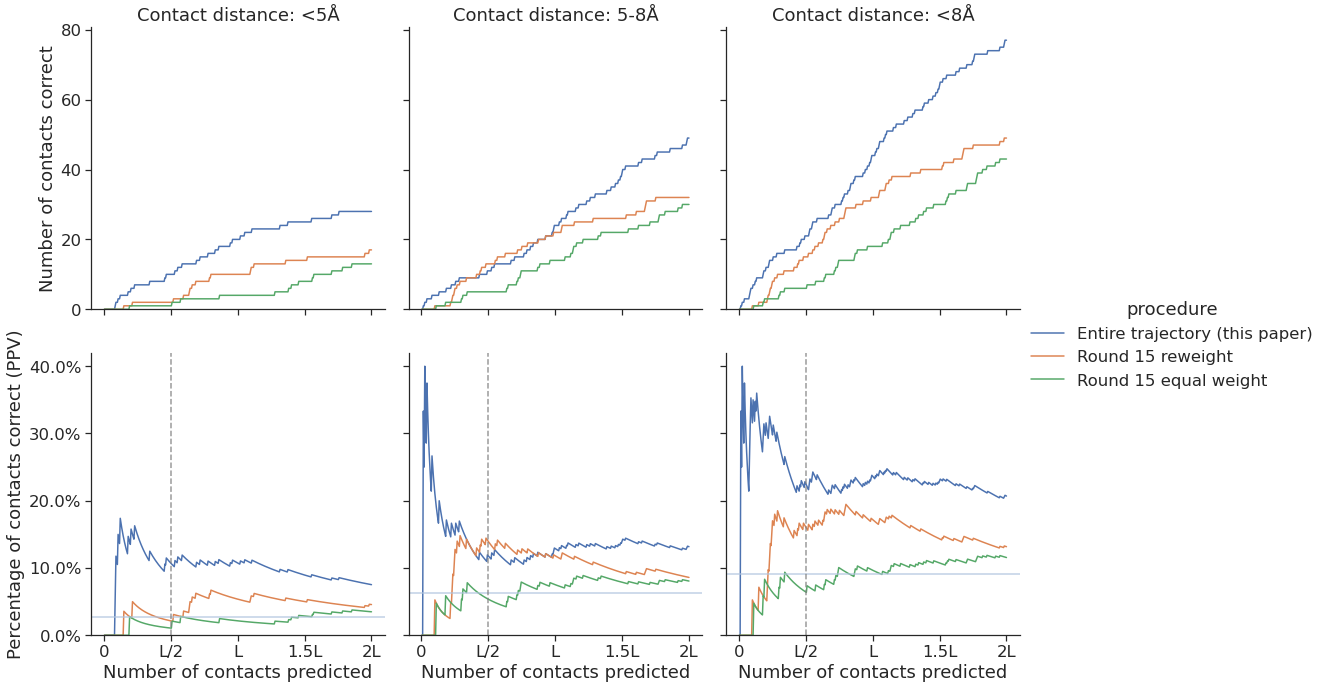

In [32]:
sns.set_theme(font_scale=1.5, style="ticks")
g = sns.relplot(x="num_predicted", y="value", hue="procedure", kind="line", 
                col="contact_type", row="variable", facet_kws={'sharex':True, 'sharey':'row'}, 
                data=df_to_plot_melt)

random_expectation_kws = {"alpha":0.8, "linestyle":"-", "color":"lightsteelblue"}
half_l_kws = {"alpha":0.8, "linestyle":"--", "color":"grey"}


for key, ax in g.axes_dict.items():
    variable, contact_type = key
    if variable == "pct_correct_ppv":
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        if contact_type == "<5A":
            ax.set_ylabel("Percentage of contacts correct (PPV)")
            ax.axhline(random_expectation_5, **random_expectation_kws)
        elif contact_type == "5-8A":
            ax.axhline(random_expectation_5to8, **random_expectation_kws)
        elif contact_type == "<8A":
            ax.axhline(random_expectation_8, **random_expectation_kws)
        ax.set_xlabel("Number of contacts predicted")
        ax.set_title("")
        ax.axvline(config.L/2, **half_l_kws)

        ax.set_xticks([0, config.L/2, config.L, 1.5*L, 2*config.L])
        ax.set_xticklabels([0, "L/2", "L", "1.5L", "2L"])
    else: # num_correct
        if contact_type == "<5A":
            ax.set_ylabel("Number of contacts correct")
            ax.set_title(r'Contact distance: <5Å')
        elif contact_type == "5-8A":
            ax.set_title(r'Contact distance: 5-8Å')
        elif contact_type == "<8A":
            ax.set_title(r'Contact distance: <8Å')
    ax.set_ylim(ymin=0)


#plt.tight_layout()
plt.subplots_adjust(left=0.10, bottom=0.10)
plt.savefig(f"{config.ASSETS_DIR}/contacts_recovered.png", dpi=300)
plt.savefig(f"{config.ASSETS_DIR}/contacts_recovered.eps")

        

In [33]:
df_to_plot[df_to_plot.num_predicted == 93]

,procedure,num_predicted,contact_type,num_correct,pct_correct_ppv
92,Entire trajectory (this paper),93,<5A,10,0.107527
464,Entire trajectory (this paper),93,5-8A,11,0.118280
836,Entire trajectory (this paper),93,<8A,21,0.225806
92,Round 15 reweight,93,<5A,2,0.021505
464,Round 15 reweight,93,5-8A,13,0.139785
836,Round 15 reweight,93,<8A,15,0.161290
92,Round 15 equal weight,93,<5A,1,0.010753
464,Round 15 equal weight,93,5-8A,5,0.053763
836,Round 15 equal weight,93,<8A,6,0.064516


In [34]:
L_mapping = {int(config.L/5):"L/5", int(config.L/2):"L/2", int(config.L):"L", int(config.L*2):"2L"}

In [35]:
df_comparison = df_to_plot[df_to_plot.num_predicted.isin(L_mapping.keys())].copy()
df_comparison["num_predicted"].replace(L_mapping, inplace=True)

In [36]:
df_comparison_pivot = df_comparison.pivot_table(index=["num_predicted", 'procedure'], 
                          columns=["contact_type"], values="pct_correct_ppv")
df_comparison_pivot = df_comparison_pivot[::-1].copy()
df_comparison_pivot = df_comparison_pivot[['<5A', '5-8A', '<8A']].copy()
best_methods_idxs = [[idx, df_split.idxmax()] for idx, df_split in df_comparison_pivot.groupby(level=0)]

df_comparison_pivot = df_comparison_pivot.applymap(lambda x: f"{x*100:.2f}\%")
df_comparison_pivot

contact_type                                      <5A     5-8A      <8A
num_predicted procedure                                                
L/5           Round 15 reweight                2.70\%   2.70\%   5.41\%
              Round 15 equal weight            2.70\%   5.41\%   8.11\%
              Entire trajectory (this paper)  13.51\%  16.22\%  29.73\%
L/2           Round 15 reweight                2.15\%  13.98\%  16.13\%
              Round 15 equal weight            1.08\%   5.38\%   6.45\%
              Entire trajectory (this paper)  10.75\%  11.83\%  22.58\%
L             Round 15 reweight                5.38\%  11.83\%  17.20\%
              Round 15 equal weight            2.15\%   7.53\%   9.68\%
              Entire trajectory (this paper)  10.75\%  12.90\%  23.66\%
2L            Round 15 reweight                4.57\%   8.60\%  13.17\%
              Round 15 equal weight            3.49\%   8.06\%  11.56\%
              Entire trajectory (this paper)   7.53\%  13.17\%  20.70\%

In [37]:
str_best_cell = r"\cellcolor{blue!25}"

for idx, best_methods_idx in best_methods_idxs:
    for i in range(best_methods_idx.shape[0]):
        df_comparison_pivot.loc[best_methods_idx[i], best_methods_idx.index[i]] = \
            df_comparison_pivot.loc[best_methods_idx[i], best_methods_idx.index[i]] + str_best_cell

In [38]:
df_comparison_pivot.columns = [r'\textless 5\angstrom', r'5-8\angstrom', r'\textless 8\angstrom']
df_comparison_pivot.index.names = ["Number of predictions", "Method"]

In [39]:
contact_method_comparison = pathlib.Path(config.ASSETS_DIR)/"contact_method_comparison.tex"
with open(contact_method_comparison, "wt") as fh:
    print(df_comparison_pivot.to_latex(escape=False, multirow=True,
                                      column_format="llrrr",
                                      label="table:contact_method_comparison",
                                      caption=r"PPV of Long range Contacts recovered by different methods. $L=186$"), file=fh)

In [40]:
top_contacts_to_plot = results_top[["i", "j"]][:int(L/2)]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


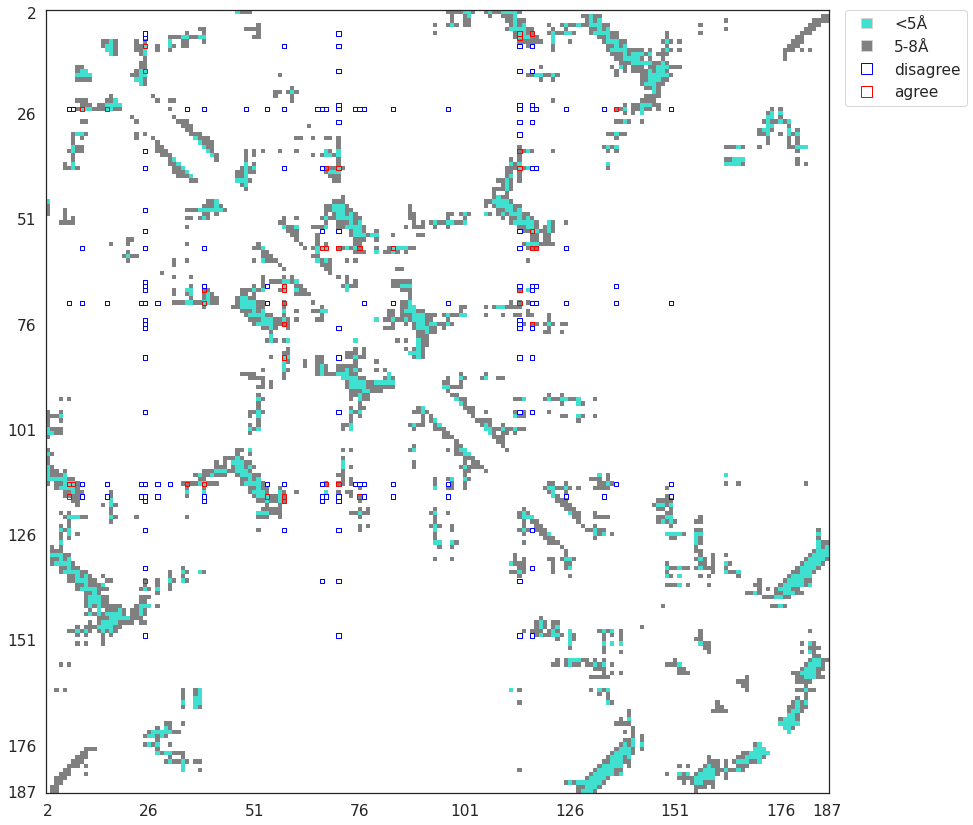

In [41]:
sns.set(style="white", font_scale=1.4)

fig = plot_utils.plot_top_contacts(top_contacts_idx1=top_contacts_to_plot.i, top_contacts_idx2=top_contacts_to_plot.j,
                     contact_map=contact_mat)

tick_positions = list(range(0, L, 25))
tick_positions[0] = 1
tick_positions.append(L)

tick_loc = [t-1 for t in tick_positions]
tick_label = [str(t+1) for t in tick_positions] # uniprot indexing

plt.xticks(ticks=tick_loc, labels=tick_label)
plt.yticks(ticks=tick_loc, labels=tick_label)

plt.subplots_adjust(right=0.85)
plt.savefig(f"{config.ASSETS_DIR}/contacts_on_map.png", dpi=300)
plt.savefig(f"{config.ASSETS_DIR}/contacts_on_map.eps")


pass


In [42]:
results_top

,i,j,frob,contact,ijdiff,wt_i,wt_j,uniprot_i,uniprot_j,uniprot_func_i,uniprot_func_j
21459,69,115,0.000208,no contact,46,R,G,71,117,Binding Site,Binding Region
12857,23,69,0.000175,no contact,46,W,R,25,71,None,Binding Site
20901,69,112,0.000164,5-8A,43,R,W,71,114,Binding Site,None
21413,23,115,0.000162,no contact,92,W,G,25,117,None,Binding Region
12890,56,69,0.000157,5-8A,13,W,R,58,71,None,Binding Site
...,...,...,...,...,...,...,...,...,...,...,...
28662,18,154,0.000008,no contact,136,N,K,20,156,Binding Region,None
34303,79,184,0.000008,no contact,105,K,K,81,186,None,None
26244,18,141,0.000008,no contact,123,N,F,20,143,Binding Region,None
34242,18,184,0.000008,no contact,166,N,K,20,186,Binding Region,None


In [43]:
frob_pivot = pd.pivot_table(results_top, index="uniprot_i", columns="uniprot_j", values="frob" )
contact_pivot = pd.pivot(results_top, index="uniprot_i", columns="uniprot_j", values="contact" )

In [44]:
frob_pivot.to_csv(f"{config.ASSETS_DIR}/frobenius_pivot.csv")

<AxesSubplot:xlabel='uniprot_j', ylabel='uniprot_i'>

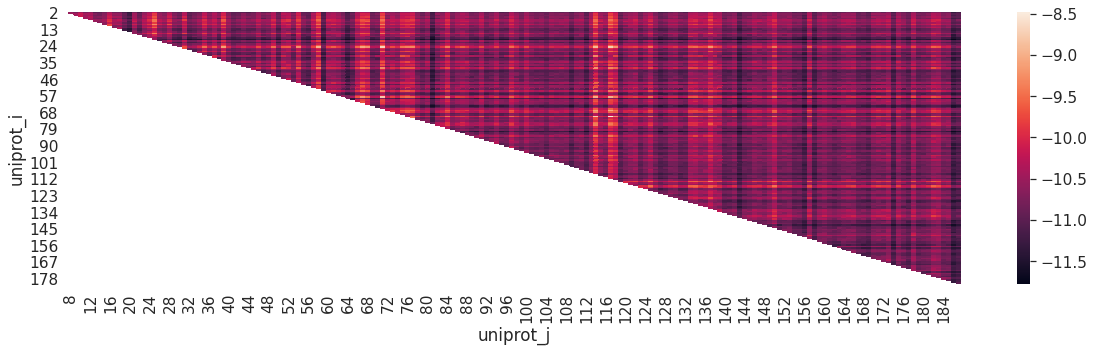

In [45]:
plt.figure(figsize=(20, 5))
sns.heatmap(np.log(frob_pivot))

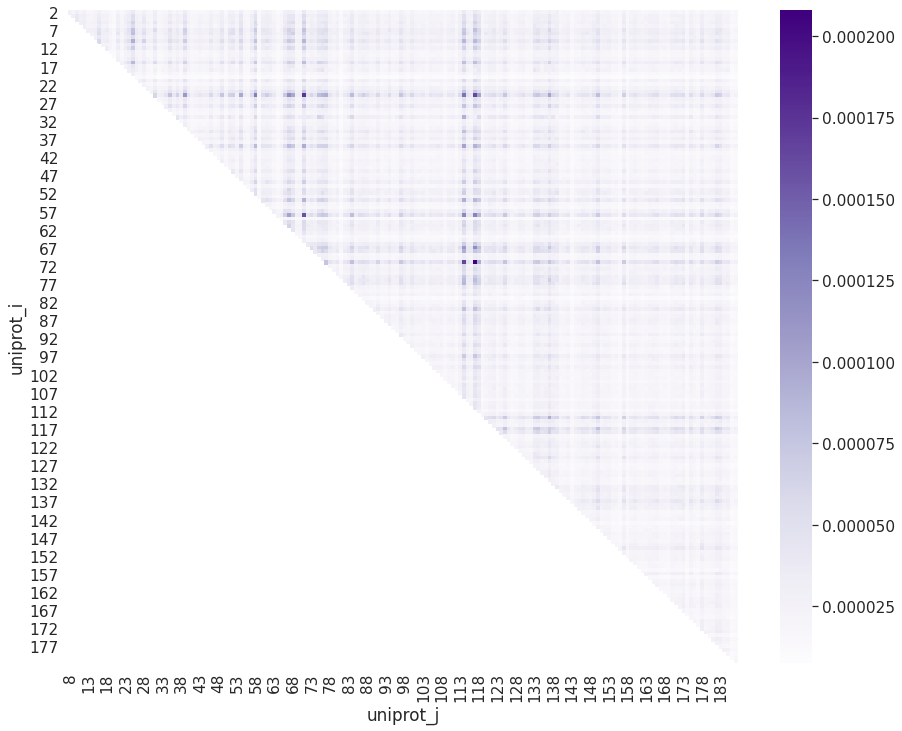

In [46]:
import matplotlib.lines as lines

plt.figure(figsize=(15, 12))
ax = plt.gca()

sns.heatmap(frob_pivot, cmap="Purples", ax=ax)

plt.savefig(f"{config.ASSETS_DIR}/frob_norm_on_map.png", dpi=300)
plt.savefig(f"{config.ASSETS_DIR}/frob_norm_on_map.eps")
pass

#sns.heatmap((contact_pivot == "5-8A").astype(int), cmap="Purples", ax=ax, cbar=False)


# # nucleotide binding in https://www.uniprot.org/uniprot/P00375
# for start, end in [(10,10), (16,22), (55,57), (77,79), (117,124)]:
#     ax.axvspan(start - 0.5 - 7, end + 0.5 - 7, color='lightgray', alpha=0.2)
#     ax.axhspan(start - 0.5 - 7, end + 0.5 - 7, color='lightgray', alpha=0.2)

    
# for start, end in [(65,65), (71,71)]:
#     ax.axvspan(start - 0.5 - 7, end + 0.5 - 7, color='moccasin', alpha=0.2)    
#     ax.axhspan(start - 0.5 - 7, end + 0.5 - 7, color='moccasin', alpha=0.2)    

    
# legend_lines = [lines.Line2D([0], [0], color="lightgray", lw=4),
#                 lines.Line2D([0], [0], color="moccasin", lw=4)
#                ]
# ax.legend(legend_lines, ['Nucleotide Binding', 'Substrate Binding'])
# pass

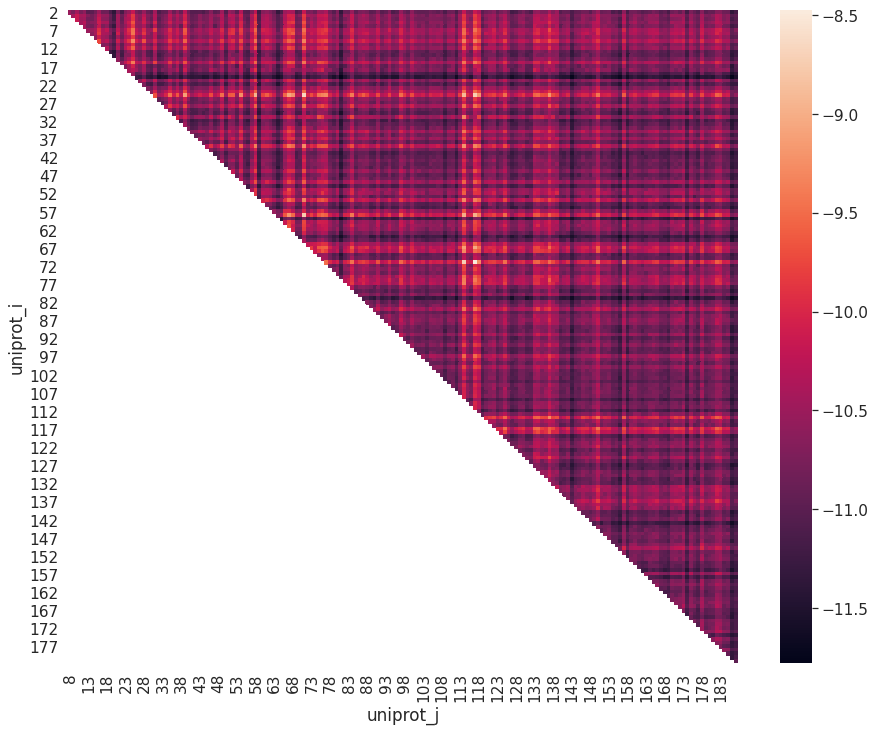

In [47]:
import matplotlib.lines as lines

plt.figure(figsize=(15, 12))
ax = plt.gca()

sns.heatmap(np.log(frob_pivot), ax=ax)

plt.savefig(f"{config.ASSETS_DIR}/log_frob_norm_on_map.png", dpi=300)
plt.savefig(f"{config.ASSETS_DIR}/log_frob_norm_on_map.eps")
pass

In [53]:
results_top_unfiltered = get_top_results_from_scores(scores, filter_close=False)
frob_pivot_unfiltered = pd.pivot_table(results_top_unfiltered, index="uniprot_i", columns="uniprot_j", values="frob")
frob_pivot_unfiltered.to_csv(f"{config.ASSETS_DIR}/frobenius_pivot_unfiltered.csv")

In [58]:
scores[scores.i == 0]

,i,j,frob
0,0,0,0.000000
186,0,1,0.000000
372,0,2,0.000000
558,0,3,0.000000
744,0,4,0.000000
...,...,...,...
33666,0,181,0.000023
33852,0,182,0.000019
34038,0,183,0.000019
34224,0,184,0.000012
